In [ ]:
# 문제 유형별로 network를 만드는 방법을 익혀보자.

# tf.data 모듈
- data를 처리하기 위한 pipeline을 제작할 수 있도록 해주는 module이다.
    - 모델 학습/평가를 위한 데이터셋을 제공(feeding)하기 위한 모듈
   - raw dataset 에서 입력을 위한 **전처리**, **배치 크키**, **shuffling**등을 한번에 처리할 수 있게 한다.
   - raw data set을 한번에 preprocessing해주는 pipeline을 제공하는 module이다.
- tf.data.Dataset 추상클래스에서 상속된 여러가지 클래스들을 제공
    - 입력 소스의 제공 형태, 어떤 처리를 하는지에 따라 다양한 하위클래스들이 제공된다.

## Dataset API 사용
1. **Dataset 생성**
    - raw dataset을 지정 (Loading)
    - from_tensor_slices(), from_generator() 클래스 메소드, tf.data.TFRecordDataset 클래스등를 사용해 메모리나 파일에 있는 데이터를 Dataset으로 만든다.
    - **from_tensor_slices()**: 메모리의 리스트, 넘파이배열, 텐서플로 자료형에서 데이터를 생성한다.
    - pipeline으로 data를 읽어오는 역할을 한다.

2. **제공 데이터 전처리**
    - **map(함수)**: Dataset이 제공하는 원소를 처리해서 변환된 원소를 제공하도록 한다.
        - 함수: 원소를 어떻게 변환할 지 정의한 함수를 매개변수로 전달한다.
            - 매개변수: Dataset이 제공하는 원소를 받을 변수. 
            - 반환값: Dataset이 제공한 원소를 변경처리한 값.
    - **filter(함수)**: Dataset이 제공하는 원소중 특정 조건을 만족하는(True)인 원소들만 제공한다.
        - 함수: 원소가 특정조건을 만족하는지 여부를 확인하는 로직을 정의한 함수를 매개변수로 전달한다.
            - 매개변수: Dataset이 제공하는 원소를 받을 변수.
            - 반환값: Dataset이 제공한 원소가 특정조건을 만족하는지 여부(bool)

3. **데이터 제공 설정 관련**
    - **batch(size)**: 학습/평가시 한번에 제공할 batch size 지정
        - size: int. batch size 지정
        - drop_remainder: bool. True일 경우 마지막 제공시 남은 데이터수가 batch size보다 작으면 제공하지 않는다.
    - **shuffle(buffer 크기)**: dataset의 원소들의 순서를 섞는다. 
        - buffer 크기: int. buffer 크기는 섞는 공간의 크기로  **데이터보다 크거나 같으면** 완전셔플, **적으면 일부만 가져와서 섞어** 완전셔플이 안된다.
        - 데이터 사이즈가 너무 커서 메모리가 부족할 경우 버퍼크기를 적게 준다.
        - 메모리가 충분하다면 데이터의 개수와 동일하게 주면된다.

- 각 tf.data 함수들은 각 기능에 맞게 데이터를 처리하는 Dataset 객체를 반환한다.

### Dataset 메소드
- take(개수): 지정한 개수만큼의 데이터만 제공한다.

In [1]:
import tensorflow as tf
import numpy as np

##### Tensor Type
>- TensorFlow의 기본 data structure이다.
>- numpy가 ndarray를 이용해 데이터를 관리하듯이 tensorflow는 Tensor를 이용해 데이터를 관리한다.
>    - Tesorflow의 모델이 학습, 평가할때 사용하는 데이터셋(train dataset, validation dataset, test dataset)은 tf.Tensor 타입이어야 한다.
>        - 학습/평가(model.fit(), model.evaluate()) 할때 ndarray를 입력 데이터셋으로 넣어주면 내부적으로 tf.Tensor로 변형해서 처리.
>        - tf.Tensor는 데이터셋을 ndarray로 가지고 있다.
> - ndarray를 넣으면 자동으로 tensor type으로 바꿔준다.

In [4]:
# 간단한 Tensor type의 data를 만들어보자. 쉽게 생각해 numpy의 ndarray를 만드는 것과 같다.
t = tf.constant([1, 2, 3], dtype = 'float32')
t

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [6]:
type(t), t.shape, t.dtype

(tensorflow.python.framework.ops.EagerTensor, TensorShape([3]), tf.float32)

In [7]:
# Tensor를 ndarray로 변환하는 방법
n = t.numpy()
n

array([1., 2., 3.], dtype=float32)

In [8]:
type(n), n.shape, n.dtype

(numpy.ndarray, (3,), dtype('float32'))

In [10]:
# ndarray 혹은 list를 Tensor로 변환하는 방법
# tf.constant는 np.array와 같은 것이다.

tf.constant(np.arange(10))

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])>

In [12]:
tf.convert_to_tensor(n)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

## Dataset 예제

In [ ]:
# TensorSliceDataset은 data를 가지고 있지 않다. 메모리 상에 저장된 ndarray를 읽어오는 것 뿐이다.
# 이 점을 분명히 알고 있어야 한다. TensorSliceDataset은 data를 가지고 있지 않다.
# pipeline의 data를 읽어오는 역할을 수행한다.

In [13]:
# 0 ~ 9의 정수를 input data로 설정해 처리 과정을 확인해보자.
raw_data1 = np.arange(10)
raw_data1

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [22]:
# Dataset을 생성해보자. 대상 raw data set이 메모리에 있는 ndarray일 때만 가능하다.
# ndarray data set을 Dataset pipeline으로 읽어오는 역할을 하는 것이 TensorSliceDataset이다.
# 읽어오는 순간 data는 Tensor type으로 변환된다.
dataset1 = tf.data.Dataset.from_tensor_slices(raw_data1)
print(type(dataset1))

<class 'tensorflow.python.data.ops.from_tensor_slices_op.TensorSliceDataset'>


In [23]:
# Dataset은 iterable type이다. 그래서 fon in문으로 처리가 가능하다.
for data in dataset1:
    print(data)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [24]:
# dataset에서 element를 원하는 개수만큼만 조회하고자 할 때 .take()를 사용한다.
# 이때 원하는 개수를 정수로 입력한다. 값을 미리 확인해볼 때 주로 사용한다.
for data in dataset1.take(3):
    print(data)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


##### x, y 묶어서 제공
- 두개 이상의 데이터셋을 묶어서 제공할 경우 Tuple로 묶어준다.
    - Dataset이 feeding 할 때는 같은 index의 값들을 tuple로 묶어서 제공 (zip()과 동일)

In [20]:
raw_data2 = np.arange(10, 20)
print(raw_data1, len(raw_data1))
print(raw_data2, len(raw_data2))

[0 1 2 3 4 5 6 7 8 9] 10
[10 11 12 13 14 15 16 17 18 19] 10


In [25]:
dataset2 = tf.data.Dataset.from_tensor_slices( (raw_data1, raw_data2) )

for data in dataset2.take(3):
    print(data)

(<tf.Tensor: shape=(), dtype=int32, numpy=0>, <tf.Tensor: shape=(), dtype=int32, numpy=10>)
(<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=11>)
(<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=12>)


In [ ]:
# 하나의 tuple 안에 두 개의 Tensor가 들어있는 형식으로 결과가 반환된다.
# 두 dataset의 같은 index의 값들을 tuple로 묶어서 반환한다.

In [26]:
for x, y in dataset2:
    print(x, y, sep = ' ')

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32) tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32) tf.Tensor(13, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32) tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32) tf.Tensor(15, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32) tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32) tf.Tensor(17, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32) tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32) tf.Tensor(19, shape=(), dtype=int32)


##### shuffle
- 데이터셋을 섞는다.

In [27]:
raw_data = range(10)
dataset = tf.data.Dataset.from_tensor_slices(raw_data)
for data in dataset:
    print(data)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [59]:
dataset_shuffle = dataset.shuffle(10)

print(type(dataset_shuffl))

<class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>


In [60]:
# shuffle을 사용하면 ShuffleDataset type으로 Dataset을 바꾼다.

In [61]:
for data in dataset_shuffle:
    print(data)

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)


In [44]:
# ShuffleDataset 역시 data를 가지고 있지 않다. Dataset으로부터 data를 읽어와 data의 순서를 섞어 출력하는 것일 뿐이다.
# method를 chainning하여 하나의 pipeline으로 만드는 것이다.
# 그리고 이 pipeline을 network에 전달한다.

##### batch
- drop_remainder: boolean(기본-False)
    - batch로 제공할 데이터의 개수가 설정한 batch_size 보다 적으면 제공하지 않는다.
    - Train dataset을 만들때 True로 설정하여 항상 일정한 batch size로 학습할 수 있도록 한다. drop 되는 데이터는 다른 epoch을 반복할 때 사용된다.

In [49]:
dataset_batch = dataset.batch(5)
print(type(dataset_batch))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [50]:
# BatchDataset이 만들어진 것을 확인할 수 있다.

In [52]:
for data in dataset_batch:
    print(data)

tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int32)
tf.Tensor([5 6 7 8 9], shape=(5,), dtype=int32)


In [53]:
# 입력한 개수만큼 data를 묶어 반환한다.

In [54]:
dataset_batch = dataset.batch(3)
for data in dataset_batch:
    print(data)

tf.Tensor([0 1 2], shape=(3,), dtype=int32)
tf.Tensor([3 4 5], shape=(3,), dtype=int32)
tf.Tensor([6 7 8], shape=(3,), dtype=int32)
tf.Tensor([9], shape=(1,), dtype=int32)


In [ ]:
# 딱 맞아떨어지지 않는 경우 위와 같이 남는 data는 따로 반환한다.

In [55]:
dataset_batch = dataset.batch(3, drop_remainder = True)
for data in dataset_batch:
    print(data)

tf.Tensor([0 1 2], shape=(3,), dtype=int32)
tf.Tensor([3 4 5], shape=(3,), dtype=int32)
tf.Tensor([6 7 8], shape=(3,), dtype=int32)


In [ ]:
# parameter drop_remainder를 True로 지정하면 남는 data는 버리고 반환한다.
# 읽어 올 data개수가 batch_size보다 작으면 제공하지 않는다.
# train data set을 생성할 때 설정한다.
# 무조건 하지는 않지만 보통의 경우 train data set을 생성할 때 drop_remainder를 True로 설정한다.
# shuffle과 같이 사용해 남는 data를 사용하지 않는 일은 없도록 한다.

##### repeat

In [ ]:
# 지정한 횟수만큼 data를 반복해서 제공한다. 기본값은 1이다.

In [58]:
dataset_repeat = dataset.repeat(2)
print(type(dataset_repeat))

<class 'tensorflow.python.data.ops.dataset_ops.RepeatDataset'>


In [57]:
for data in dataset_repeat:
    print(data)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [ ]:
# 횟수를 2로 지정해서 각 data의 반환을 2번씩 반복한다.

In [65]:
# 위 과정들은 한 줄로 작성할 수 있다.
# 아래와 같은 하나의 data preprocessing pipeline을 만드는 것이다.
# 순서가 바뀌면 data의 구성이 바뀐다. 순서에 주의하면서 Dataset의 method를 사용하도록 한다.
raw_data = np.arange(10)
dataset = tf.data.Dataset.from_tensor_slices(raw_data).shuffle(10).batch(3, drop_remainder = True).repeat(2)

In [66]:
print(type(dataset))

<class 'tensorflow.python.data.ops.dataset_ops.RepeatDataset'>


In [67]:
for data in dataset:
    print(data)

tf.Tensor([0 3 1], shape=(3,), dtype=int32)
tf.Tensor([6 7 9], shape=(3,), dtype=int32)
tf.Tensor([8 5 4], shape=(3,), dtype=int32)
tf.Tensor([1 7 9], shape=(3,), dtype=int32)
tf.Tensor([5 3 6], shape=(3,), dtype=int32)
tf.Tensor([4 0 8], shape=(3,), dtype=int32)


In [ ]:
# 실행 결과를 살펴보면 repeat을 한 번 수행할 때마다 shuffle 역시 한 번 수행하는 것을 알 수 있다.

##### map

In [71]:
# data에 일괄적인 처리를 할 때 사용한다. map 안에 처리 함수로 lambda 식은 사용할 수 없다.
raw_data = np.arange(10)
dataset = tf.data.Dataset.from_tensor_slices(raw_data)

def twice(x):
    return x * 2

dataset_map = dataset.map(twice)
print(type(dataset_map))

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [72]:
for data in dataset_map:
    print(data)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)


In [74]:
# map은 여러 개의 data를 하나로 묶은 Dataset instance에도 적용 가능하다.

dataset = tf.data.Dataset.from_tensor_slices( (np.arange(10), np.arange(10, 20)) )

def func(x, y):
    return x*2, y + 10

dataset_map = dataset.map(func)

for data in dataset_map:
    print(data)

(<tf.Tensor: shape=(), dtype=int32, numpy=0>, <tf.Tensor: shape=(), dtype=int32, numpy=20>)
(<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=21>)
(<tf.Tensor: shape=(), dtype=int32, numpy=4>, <tf.Tensor: shape=(), dtype=int32, numpy=22>)
(<tf.Tensor: shape=(), dtype=int32, numpy=6>, <tf.Tensor: shape=(), dtype=int32, numpy=23>)
(<tf.Tensor: shape=(), dtype=int32, numpy=8>, <tf.Tensor: shape=(), dtype=int32, numpy=24>)
(<tf.Tensor: shape=(), dtype=int32, numpy=10>, <tf.Tensor: shape=(), dtype=int32, numpy=25>)
(<tf.Tensor: shape=(), dtype=int32, numpy=12>, <tf.Tensor: shape=(), dtype=int32, numpy=26>)
(<tf.Tensor: shape=(), dtype=int32, numpy=14>, <tf.Tensor: shape=(), dtype=int32, numpy=27>)
(<tf.Tensor: shape=(), dtype=int32, numpy=16>, <tf.Tensor: shape=(), dtype=int32, numpy=28>)
(<tf.Tensor: shape=(), dtype=int32, numpy=18>, <tf.Tensor: shape=(), dtype=int32, numpy=29>)


##### filter

In [76]:
# filter에는 boolean type을 반환하는 함수를 넣어야 한다.
def filter_func(x):
    return x % 2 == 0

dataset = tf.data.Dataset.from_tensor_slices(np.arange(10))
dataset_filter = dataset.filter(filter_func)

for data in dataset_filter:
    print(data)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


# 문제 유형별 MLP 네트워크
- MLP(Multi Layer Perceptron), ANN(Artificial Neural Network), DNN(Deep Neural Network)
    - Fully Connected Layer로 구성된 가장 기본적인 Deep Learning network를 말한다.

In [77]:
!pip install scikit-learn

  Using cached scikit_learn-1.2.1-cp39-cp39-win_amd64.whl (8.4 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
     --------------------------------------- 42.5/42.5 MB 18.2 MB/s eta 0:00:00
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)


# Regression(회귀)

## Boston Housing Dataset
보스턴 주택가격 dataset은 다음과 같은 속성을 바탕으로 해당 타운 주택 가격의 중앙값을 예측하는 문제.
- CRIM: 범죄율
- ZN: 25,000 평방피트당 주거지역 비율
- INDUS: 비소매 상업지구 비율
- CHAS: 찰스강에 인접해 있는지 여부(인접:1, 아니면:0)
- NOX: 일산화질소 농도(단위: 0.1ppm)
- RM: 주택당 방의 수
- AGE: 1940년 이전에 건설된 주택의 비율
- DIS: 5개의 보스턴 직업고용센터와의 거리(가중 평균)
- RAD: 고속도로 접근성
- TAX: 재산세율
- PTRATIO: 학생/교사 비율
- B: 흑인 비율
- LSTAT: 하위 계층 비율
<br><br>
- **Target**
    - MEDV: 타운의 주택가격 중앙값(단위: 1,000달러)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler

import random

In [2]:
# random seed 값 설정
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

##### 데이터 로딩

In [3]:
(train_X, y_train), (test_X, y_test) = keras.datasets.boston_housing.load_data()

print(train_X.shape, y_train.shape)
print(test_X.shape, y_test.shape)

(404, 13) (404,)
(102, 13) (102,)


In [4]:
train_X, val_X, y_train, y_val = train_test_split(train_X, y_train, test_size = 0.2, random_state = 0)

In [5]:
print(train_X.shape, y_train.shape)
print(val_X.shape, y_val.shape)
print(test_X.shape, y_test.shape)

(323, 13) (323,)
(81, 13) (81,)
(102, 13) (102,)


In [6]:
train_X[0]

array([  8.98296,   0.     ,  18.1    ,   1.     ,   0.77   ,   6.212  ,
        97.4    ,   2.1222 ,  24.     , 666.     ,  20.2    , 377.73   ,
        17.6    ])

In [7]:
train_X[0].shape

(13,)

In [8]:
y_train[0]

17.8

##### 하이퍼파라미터, 변수 정의

In [9]:
# hyper parameter와 변수는 미리 한번에 설정하는 것이 관라하는 데에 편하다.

# 학습률 alpha 정의
# gradient descent에서 사용할 값으로 0 ~ 1 사이의 실수를 정의한다. optimizer를 생성할 때 사용한다.
LEARNING_RATE = 0.001

# epoch 수 정의
N_EPOCH = 200

# train Dataset의 batch_size 정의
N_BATCH = 323

# vlidation Dataset / evaluation의 batch_size 정의
N_BATCH_VAL = 50

# test Dataset의 batch_size 정의
N_BATCH_TEST = 50

##### X, y 전처리
- MLP는 선형모델을 기반으로 하므로 Feature scaling을 해준다.
- 본 문제는 regression이므로 y는 그대로 둔다.

In [10]:
scaler = StandardScaler()

X_train = scaler.fit_transform(train_X)
X_val = scaler.transform(val_X)
X_test = scaler.transform(test_X)

In [11]:
X_train.mean(), X_train.std()

(1.700632172990952e-15, 1.0)

##### Dataset 생성

- validation/test set의 pipe line은 동일하게 구성한다.
- train dataset은 shuffle을 추가하고 batch에 drop_remainder=True를 설정한다.
- map, filter 를 pipe line에 추가할 경우 train/validation/test set에 모두 동일하게 적용한다.

In [12]:
# train Dataset은 shuffle을 해야하지만 validation / test Dataset은 shuffle을 할 필요가 없다.
# 어차피 결과의 평균으로 network를 평가하기 때문이다.

# train Dataset은 batch에서 drop_remainder = True로 설정해야 하지만 vlidation / test Dataset은 그렇게 설정하지 않는다.

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(X_train.shape[0]).batch(N_BATCH, drop_remainder = True)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(N_BATCH_VAL)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCH_TEST)

In [14]:
print('1 epoch당 train Dataset의 step 수:', len(train_dataset))
print('1 epoch당 validation Dataset의 step 수:', len(val_dataset))
print('1 epoch당 test Dataset의 step 수:', len(test_dataset))

1 epoch당 train Dataset의 step 수: 1
1 epoch당 validation Dataset의 step 수: 2
1 epoch당 test Dataset의 step 수: 3


In [15]:
# X_train은 data point의 수가 404개였다. batch_size를 400으로 설정했기 때문에 1 epoch을 실행할 때 1 step을 실행한다.
# X_test는 data point의 수가 81개였다. batch_size를 50으로 설정했기 때문에 1 epoch을 실행할 때 2 step을 실행한다.
# X_test는 data point의 수가 102개였다. batch_size를 50으로 설정했기 때문에 1 epoch을 실행할 때 3 step을 실행한다.

##### 모델 구현

1. 모델 객체 생성 - Sequential
2. 모델에 Layer들 추가
    - Input Layer 추가
        - 입력 데이터의 shape을 지정한다.
        1. InputLayer 객체를 생성해서 추가한다.
        2. 첫번째 Hidden Layer에 input_shape 매개변수에 shape을 지정하여 추가한다.
    - Hidden Layer들 추가
        - Layer의 개수와 Layer의 Unit의 개수는 튜닝대상으로 성능에 영향을 준다.
        - 활성함수는 ReLU 를 사용한다.
        - Layer의 개수와 Unit 개수가 많을 수록 복잡한 모델, 적을 수록 단순한 모델이된다.
    - Output Layer 추가
        - 풀려는 문제에 따라 unit개수와 각 활성함수를 지정한다.
        - 보통 regression 문제에서는 activation function을 설정하지 않는다. parameter activation의 기본값은 None이므로 아무런 설정을 하지 않아도 된다.
        - 값의 범위를 맞추기 위해 sigmoid function이나 hyperbolic tangent function을 사용하기도 한다.
            - sigmoid funcion은 출력 값이 0 ~ 1인 경우 사용한다.
            - hyperbolic tangent function은 출력 값이 -1 ~ 1인 경우 사용한다.

In [16]:
# InputLayer는 Hidden Layer의 첫 번째 lyaer에 input_shape을 parameter로 설정함으로써 생략할 수 있다.
# activation function역시 각 layer에 parameter로 추가함으로써 직접 layer를 activation function layer를 설정하지 않아도 된다.

In [17]:
# model을 생성하는 함수를 정의해 사용한다. 관리를 좀 더 편하게 하기 위함이다.
def get_model_boston(lr = 0.01):
    model = keras.Sequential()
    
    # Network 정의
    # Hidden Layer - Input Layer는 Hidden Layer의 첫 번째 layer에 같이 설정
    model.add(layers.Dense(units = 32, activation = 'relu', input_shape = (13, )))
    model.add(layers.Dense(units = 16, activation = 'relu'))
    model.add(layers.Dense(units = 8, activation = 'relu'))
    # Ouput Layer
    model.add(layers.Dense(units = 1))
    
    # Network Compile
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), 
                  loss = 'mse')
    
    return model

In [18]:
# 위 함수를 이용해 network를 생성해보자.
# model_boston = get_model_boston(LEARNING_RATE)
model_boston = get_model_boston()
model_boston.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


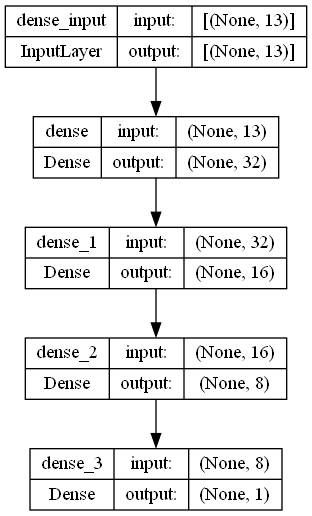

In [19]:
keras.utils.plot_model(model_boston, show_shapes = True)

##### 학습(Train)

In [20]:
# 위에서 train_dataset을 생성했다. 그래서 network를 학습시킬 때 train_dataset을 전달하면 된다.
# 다른 설정은 모두 train_dataset에 되어있으므로 epoch만 설정하면 된다.
# 그리고 validation Dataset은 validation_data로 지정한다.
history_boston = model_boston.fit(train_dataset, 
                                  epochs = N_EPOCH, 
                                  validation_data = val_dataset
                                  )

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 602.3062 - val_loss: 532.8664
Epoch 2/200
1/1 [==============================] - 0s 52ms/step - loss: 593.8774 - val_loss: 526.0972
Epoch 3/200
1/1 [==============================] - 0s 56ms/step - loss: 586.3717 - val_loss: 518.1393
Epoch 4/200
1/1 [==============================] - 0s 58ms/step - loss: 578.0090 - val_loss: 509.2076
Epoch 5/200
1/1 [==============================] - 0s 56ms/step - loss: 568.0285 - val_loss: 499.1311
Epoch 6/200
1/1 [==============================] - 0s 55ms/step - loss: 556.5242 - val_loss: 487.4049
Epoch 7/200
1/1 [==============================] - 0s 54ms/step - loss: 543.1180 - val_loss: 473.5567
Epoch 8/200
1/1 [==============================] - 0s 55ms/step - loss: 527.2007 - val_loss: 457.4460
Epoch 9/200
1/1 [==============================] - 0s 53ms/step - loss: 508.2335 - val_loss: 438.5789
Epoch 10/200
1/1 [==============================] - 0s 53ms/step - loss: 485.9183 - 

1/1 [==============================] - 0s 43ms/step - loss: 12.7555 - val_loss: 11.9407
Epoch 82/200
1/1 [==============================] - 0s 52ms/step - loss: 12.5724 - val_loss: 11.8079
Epoch 83/200
1/1 [==============================] - 0s 52ms/step - loss: 12.4161 - val_loss: 11.7031
Epoch 84/200
1/1 [==============================] - 0s 53ms/step - loss: 12.2801 - val_loss: 11.6121
Epoch 85/200
1/1 [==============================] - 0s 50ms/step - loss: 12.1475 - val_loss: 11.5254
Epoch 86/200
1/1 [==============================] - 0s 51ms/step - loss: 12.0071 - val_loss: 11.4441
Epoch 87/200
1/1 [==============================] - 0s 56ms/step - loss: 11.8601 - val_loss: 11.3656
Epoch 88/200
1/1 [==============================] - 0s 57ms/step - loss: 11.7113 - val_loss: 11.3021
Epoch 89/200
1/1 [==============================] - 0s 54ms/step - loss: 11.5706 - val_loss: 11.2571
Epoch 90/200
1/1 [==============================] - 0s 59ms/step - loss: 11.4383 - val_loss: 11.2259
Epo

1/1 [==============================] - 0s 53ms/step - loss: 7.0957 - val_loss: 11.4814
Epoch 163/200
1/1 [==============================] - 0s 52ms/step - loss: 7.0738 - val_loss: 11.4924
Epoch 164/200
1/1 [==============================] - 0s 57ms/step - loss: 7.0522 - val_loss: 11.5005
Epoch 165/200
1/1 [==============================] - 0s 52ms/step - loss: 7.0312 - val_loss: 11.5069
Epoch 166/200
1/1 [==============================] - 0s 51ms/step - loss: 7.0104 - val_loss: 11.5128
Epoch 167/200
1/1 [==============================] - 0s 57ms/step - loss: 6.9896 - val_loss: 11.5191
Epoch 168/200
1/1 [==============================] - 0s 58ms/step - loss: 6.9694 - val_loss: 11.5225
Epoch 169/200
1/1 [==============================] - 0s 48ms/step - loss: 6.9495 - val_loss: 11.5280
Epoch 170/200
1/1 [==============================] - 0s 51ms/step - loss: 6.9298 - val_loss: 11.5369
Epoch 171/200
1/1 [==============================] - 0s 53ms/step - loss: 6.9104 - val_loss: 11.5507
Epoc

##### 결과 시각화
- 학습 시 epoch별 검증 결과를 시각화한다.

In [21]:
history_boston.history.keys()

dict_keys(['loss', 'val_loss'])

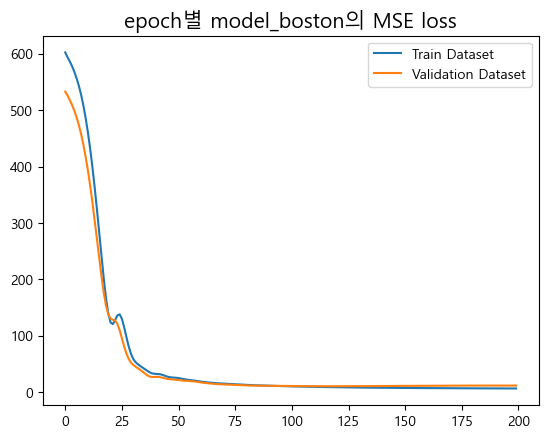

In [23]:
# history_boston.history를 이용해 epoch별 검증 결과를 확인해보자.
plt.plot(history_boston.epoch, history_boston.history['loss'], label = 'Train Dataset')
plt.plot(history_boston.epoch, history_boston.history['val_loss'], label = 'Validation Dataset')
plt.title('epoch별 model_boston의 MSE loss', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
# learning rate를 0.1로 키워서 다시해본다.


##### 최종 테스트

In [24]:
loss = model_boston.evaluate(test_dataset)

3/3 [==============================] - 0s 4ms/step - loss: 22.2656


##### 모델 네트워크 저장

In [25]:
# 이렇게 생성된 network는 따로 저장하는 것이 나중에 다시 불러서 사용하기에 좋다.

import os

path = 'saved_model'
os.makedirs(path, exist_ok = True)

In [27]:
saved_dir = os.path.join(path, 'model_boston')
model_boston.save(saved_dir)

INFO:tensorflow:Assets written to: saved_model\model_boston\assets


INFO:tensorflow:Assets written to: saved_model\model_boston\assets


##### 새로운 데이터 추론

In [ ]:
# 저장된 network를 불러와서 추론해보자.
saved_model = keras.models.load_model(saved_dir)
saved.model.evaluate(test_dataset)

# 분류 (Classification)

## Fashion MNIST Dataset - 다중분류(Multi-Class Classification) 문제

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋. 
이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 의류 품목을 나타낸다:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>그림</b> <a href="https://github.com/zalandoresearch/fashion-mnist">패션-MNIST 샘플</a> (Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

이미지는 28x28 크기이며 Gray scale이다. *레이블*(label)은 0에서 9까지의 정수 배열이다. 아래 표는 이미지에 있는 의류의 **클래스**(class)들이다.

<table>
  <tr>
    <th>레이블</th>
    <th>클래스</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trousers</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

각 이미지는 하나의 레이블에 매핑되어 있다. 데이터셋에 클래스 이름이 들어있지 않기 때문에 나중에 이미지를 출력할 때 사용하기 위해 별도의 변수를 만들어 저장한다.

In [37]:
class_names = ['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

##### Data 로딩

##### validatation dataset set  분리
- Train set을 Train/validation set으로 분리

##### 이미지 확인

#### 하이퍼파라미터, 변수 설정

#### X, y  전처리
- y값 처리
    - 다중 분류에서 label encoding 형식의 label을 one hot encoding 처리

- x값(이미지) 처리
    - dtype을 uint8에서 float32로 변환한다.
    - 0 ~ 1 정규화. X/255.0으로 나눈다.

##### Dataset 생성

##### 모델 생성 및 컴파일

##### Train(학습)

##### 결과 시각화
- 학습 시 epoch별 검증 결과를 시각화한다.

#### 최종평가

#### 모델저장

#### 새로운 데이터 추론

## 위스콘신 유방암 데이터셋 - 이진분류(Binary Classification) 문제

- **이진 분류 문제 처리 모델의 두가지 방법**
    1. positive(1)일 확률을 출력하도록 구현
        - output layer: units=1, activation='sigmoid'
        - loss: binary_crossentropy
    2. negative(0)일 확률과 positive(1)일 확률을 출력하도록 구현 => 다중분류 처리 방식으로 해결
        - output layer: units=2, activation='softmax', y(정답)은 one hot encoding 처리
        - loss: categorical_crossentropy
        
- 위스콘신 대학교에서 제공한 종양의 악성/양성여부 분류를 위한 데이터셋
- Feature
    - 종양에 대한 다양한 측정값들
- Target의 class
    - 0 - malignant(악성종양)
    - 1 - benign(양성종양)

##### 데이터 로딩, train/validation/test set 나누기

#### 하이퍼파라미터, 변수 정의

#### 데이터 전처리
- y (label) 처리
    - 이진 분류
        - 양성의 확률을 출력하도록 모델을 구성하는 경우 그대로 사용.
        - 양성일 확률, 음성일 확률을 출력하도록 모델을 구성하는 경우(다중분류 방식으로 처리) one hot encoding 처리한다.
- X (feature) 처리
    - 문자열(범주형): one hot encoding
    - 연속형(수치형): feature scaling

#### Dataset 생성


#### model 생성, 컴파일

#### Train(학습)

#### 결과 시각화

#### 최종평가

#### 모델저장

#### 새로운 데이터 추론

##### 모델출력결과 후처리